# チエル 日足

In [1]:
import sys

path_up = ".."
if not path_up in sys.path:
    sys.path.append(path_up)

In [2]:
import datetime

import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import mplfinance as mpf
import numpy as np
import pandas as pd
import pingouin as pg
import seaborn as sns
import yfinance as yf

from funcs.technical import psar

In [3]:
code = "3933"
symbol = f"{code}.T"
ticker = yf.Ticker(symbol)

In [10]:
# 日足で過去 1 年分のデータを取得
df = ticker.history(period="3mo", interval="1d")
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2025-06-24 00:00:00+09:00,787.0,799.0,787.0,791.0,4100,0.0,0.0
2025-06-25 00:00:00+09:00,799.0,799.0,790.0,795.0,5700,0.0,0.0
2025-06-26 00:00:00+09:00,792.0,810.0,771.0,771.0,9400,0.0,0.0
2025-06-27 00:00:00+09:00,771.0,785.0,771.0,776.0,2700,0.0,0.0
2025-06-30 00:00:00+09:00,791.0,791.0,776.0,780.0,6100,0.0,0.0
...,...,...,...,...,...,...,...
2025-09-17 00:00:00+09:00,667.0,667.0,660.0,661.0,7900,0.0,0.0
2025-09-18 00:00:00+09:00,664.0,674.0,648.0,653.0,28500,0.0,0.0
2025-09-19 00:00:00+09:00,655.0,661.0,653.0,658.0,17400,0.0,0.0


In [11]:
dt = df.tail(1).index[0]
date_str = f"{dt.month:02d}{dt.day:02d}"
date_str

'0924'

### Matplotlib の設定

In [12]:
FONT_PATH = "../fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams["font.family"] = font_prop.get_name()
plt.rcParams["font.size"] = 12

## 日足

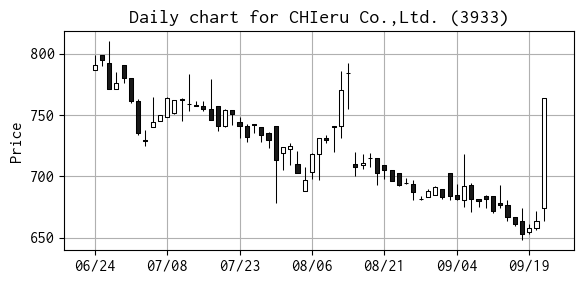

In [14]:
fig, ax = plt.subplots(figsize=(6, 3))

mpf.plot(
    df,
    type="candle",
    style="default",
    datetime_format="%m/%d",
    xrotation=0,
    update_width_config=dict(candle_linewidth=0.75),
    ax=ax,
)
ax.grid()

try:
    ax.set_title(f"Daily chart for {ticker.info["longName"]} ({code})")
except KeyError:
    ax.set_title(f"Daily chart for {symbol}")

plt.tight_layout()
plt.savefig(f"{date_str}_daily_chart_{code}.png")
plt.show()